In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import subprocess
import shutil
import warnings
from tqdm.notebook import tqdm
from collections import Counter
import copy
from typing import Dict, List, Tuple
import random

warnings.filterwarnings('ignore') # ignore warnings

# Set variables
IMAGE_DIR = '/content/result_dataset/' # directory with images
BATCH_SIZE = 128
SEED = 21 # fix random seed

torch.manual_seed(SEED)
random.seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu' # set device
print(f'Available device: {device}')

Available device: cpu


In [ ]:
! unzip '/content/drive/MyDrive/ML projects/Image classification project/Data/result_dataset.zip' -d '/'

In [4]:
%%time

data_transforms_orig = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(256, 256),
                                      interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(size=224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
])

# get original images
datasets_orig = {
    mode: torchvision.datasets.ImageFolder(root=IMAGE_DIR + mode, transform=data_transforms_orig)
    for mode in ['train', 'validation', 'test']
    }


augmentations = torchvision.transforms.RandomChoice([
    torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5)
    ]),
    torchvision.transforms.RandomRotation(degrees=(-45, 45)),
    torchvision.transforms.RandomHorizontalFlip(p=1),
    torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    torchvision.transforms.AugMix()
])

# get augmented images
data_transforms_aug = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(256, 256),
                                      interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.RandomCrop(size=224),
        augmentations,
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
])

datasets_aug = {
    mode: torchvision.datasets.ImageFolder(root=IMAGE_DIR + mode, transform=data_transforms_aug)
    for mode in ['train', 'validation']
    }

CPU times: user 126 ms, sys: 22.9 ms, total: 149 ms
Wall time: 159 ms


In [5]:
def show_images(images: List, title: str):
    """
    Show images with the title

    :param images: list of images
    :param title: title of plot with images
    """

    fig, ax = plt.subplots(1, len(images), figsize=(15, 6))
    for i, image in enumerate(images):
        ax[i].imshow(np.transpose(np.clip(image, 0, 1), (1, 2, 0)))
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=1.55)
    plt.show()

In [6]:
count = 0
orig_images = []
for image, label in iter(datasets_orig['train']):
    if count == 100:
        break
    orig_images.append(image)
    count += 1

count = 0
aug_images = []
for image, label in iter(datasets_aug['train']):
    if count == 100:
        break
    aug_images.append(image)
    count += 1

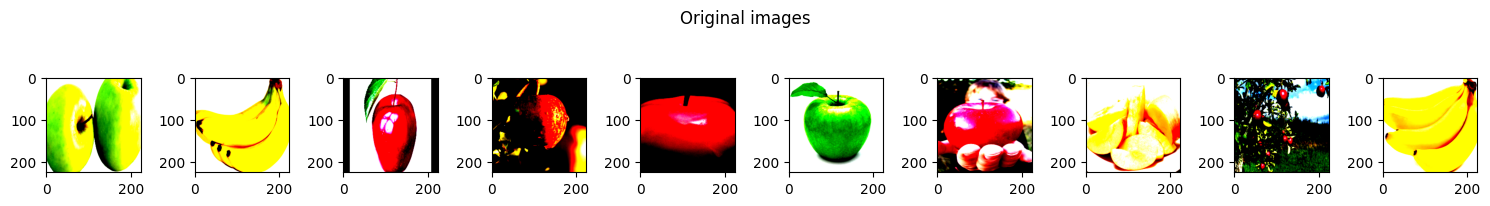

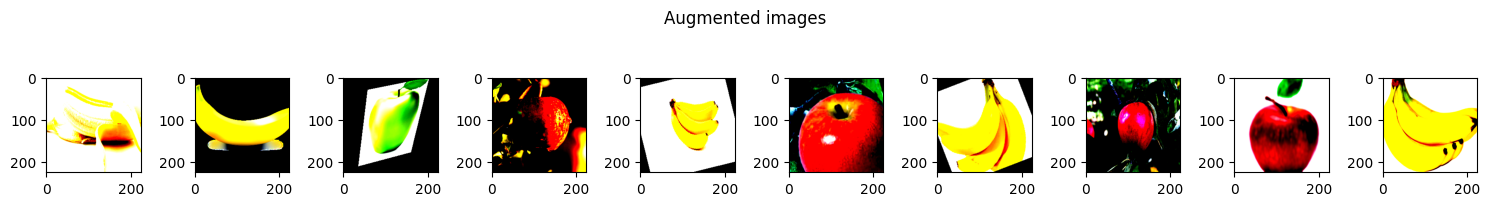

In [7]:
show_images(images=random.choices(orig_images, k=10), title='Original images')
show_images(images=random.choices(aug_images, k=10), title='Augmented images')

In [8]:
# combine original and augmented datasets
full_datasets = {
    mode: torch.utils.data.ConcatDataset([
        datasets_orig[mode],
        datasets_aug[mode]])
    for mode in ['train', 'validation']
}
full_datasets['test'] = datasets_orig['test']

In [9]:
print(f"Length of the original train dataset = {len(datasets_orig['train'])}")
print(f"Length of the original validation dataset = {len(datasets_orig['validation'])}")
print()
print(f"Length of the full train dataset with augmented data = {len(full_datasets['train'])}")
print(f"Length of the full validation dataset with augmented data = {len(full_datasets['validation'])}")

Length of the original train dataset = 19560
Length of the original validation dataset = 2174

Length of the full train dataset with augmented data = 39120
Length of the full validation dataset with augmented data = 4348


In [10]:
dataset_sizes = {
    mode: len(full_datasets[mode]) for mode in ['train', 'validation', 'test']
}

classes = full_datasets['train'].datasets[0].classes

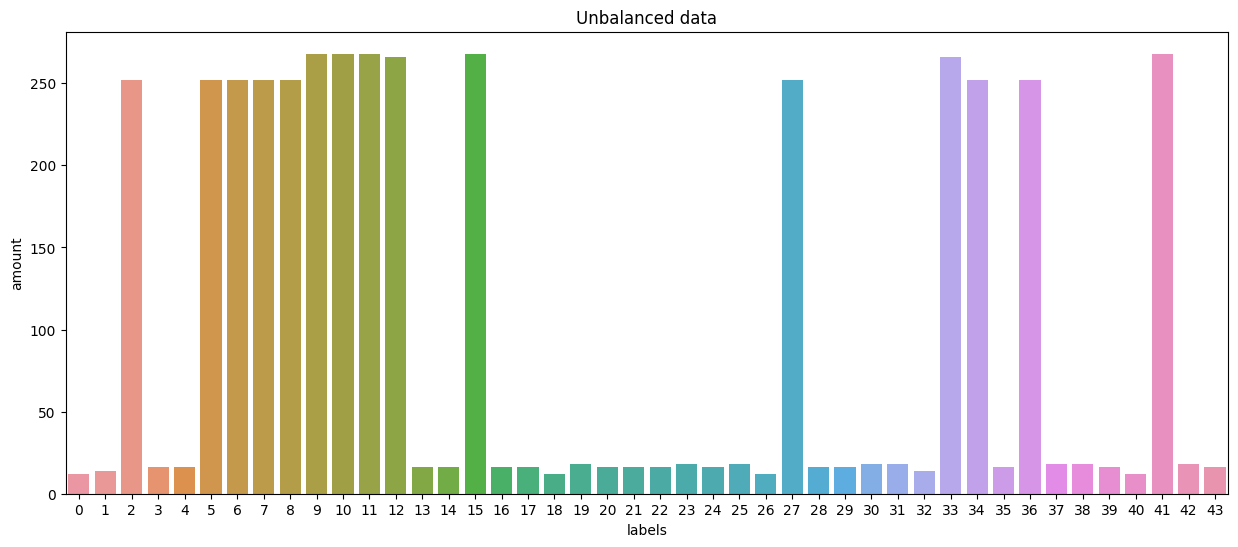

In [11]:
class_count_0 = Counter(full_datasets['validation'].datasets[0].targets)
class_count_1 = Counter(full_datasets['validation'].datasets[1].targets)
class_count = class_count_0 + class_count_1
class_df = pd.DataFrame({
    'labels': class_count.keys(),
    'amount': class_count.values()
})

plt.figure(figsize=(15, 6))
sns.barplot(data=class_df, x='labels', y='amount')
plt.title('Unbalanced data')
plt.show()

In [12]:
%%time

def get_weights_for_balanced_data(dataset) -> Tuple[List, int]:
    """
    Produce weights for do data more balanced

    :param dataset: torch dataset
    :return: tuple with weights and total number of images
    """
    if type(dataset) == torch.utils.data.dataset.ConcatDataset:
        class_count_0 = Counter(dataset.datasets[0].targets)
        class_count_1 = Counter(dataset.datasets[1].targets)
        class_count = class_count_0 + class_count_1
    elif type(dataset) == torchvision.datasets.folder.ImageFolder:
        class_count = Counter(dataset.targets)
    else:
        raise Exception("Incorrect type of dataset!")

    class_weights = {i: 1/c for i, c in class_count.items()}
    sample_weights = [0] * len(dataset)
    for i, (data, label) in enumerate(tqdm(dataset)):
        class_weight = class_weights[label]
        sample_weights[i] = class_weight
    N = max(class_count.values()) * len(class_count) # fit to max
    return sample_weights, N

dataloaders = {}

for mode in ['train', 'validation']:
    print(f'Create dataloader for {mode} dataset')
    sample_weights, N = get_weights_for_balanced_data(full_datasets[mode])
    dataset_sizes[mode] = N
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights,
                                                                num_samples=N,
                                                                replacement=True)
    dataloaders[mode] = torch.utils.data.DataLoader(full_datasets[mode],
                                                batch_size=BATCH_SIZE,
                                                sampler=train_sampler)
dataloaders['test'] = torch.utils.data.DataLoader(full_datasets['test'],
                                                batch_size=BATCH_SIZE)

Create dataloader for train dataset


  0%|          | 0/39120 [00:00<?, ?it/s]

Create dataloader for validation dataset


  0%|          | 0/4348 [00:00<?, ?it/s]

CPU times: user 6min 32s, sys: 19.5 s, total: 6min 51s
Wall time: 7min 4s


In [13]:
count = Counter()

# count number of images per class
for data, labels in tqdm(dataloaders['validation']):
    count += Counter(labels.tolist())

  0%|          | 0/93 [00:00<?, ?it/s]

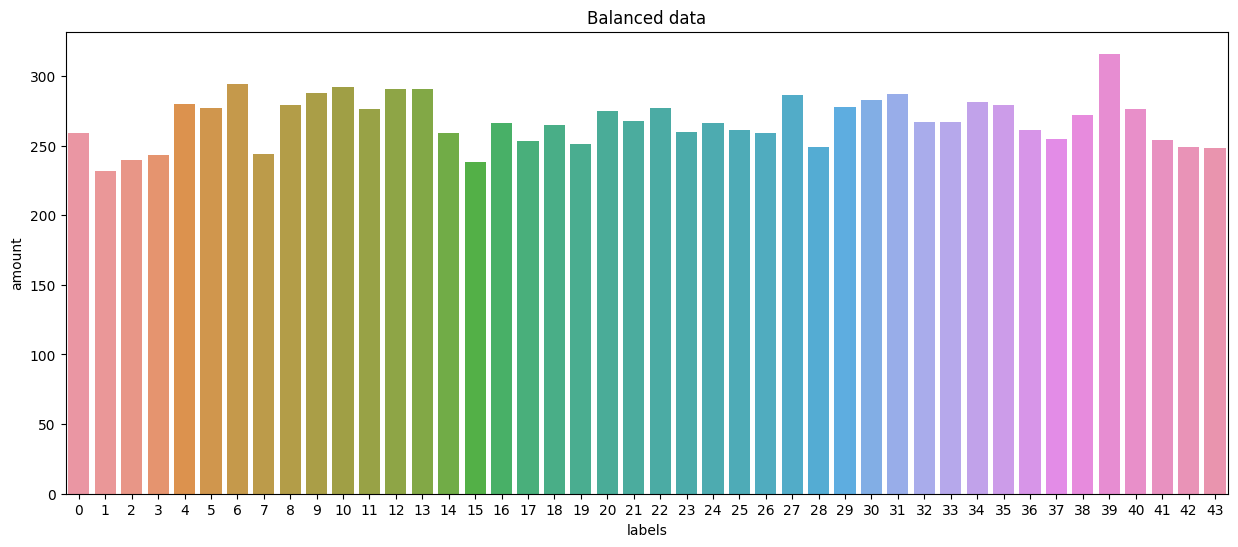

In [14]:
class_df = pd.DataFrame({
    'labels': count.keys(),
    'amount': count.values()
})

plt.figure(figsize=(15, 6))
sns.barplot(data=class_df, x='labels', y='amount')
plt.title('Balanced data')
plt.show()

In [15]:
print(f"Amount of data: {dataset_sizes['train'] + dataset_sizes['test'] + dataset_sizes['validation']}")

Amount of data: 120775


In [16]:
data, labels = next(iter(dataloaders['train']))
print(f'Data shape = {data.shape}')

Data shape = torch.Size([128, 3, 224, 224])


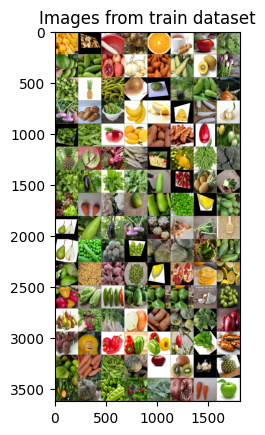

In [18]:
def show_images_in_grid(images, title: str = None):
    """
    Show images in grid

    :param images: images for showing in grid
    :param title: title of plot
    """
    image = np.transpose(images.numpy(), (1, 2, 0))
    mean_param = [0.485, 0.456, 0.406]
    std_param = [0.229, 0.224, 0.225]
    image = std_param * image + mean_param
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title != None:
        plt.title(title)
        plt.show()

images, _ = next(iter(dataloaders['train']))
images = torchvision.utils.make_grid(tensor=images)
show_images_in_grid(images=images, title='Images from train dataset')

## Train a model

In [25]:
def train_model(
    model, criterion, optimizer, scheduler,
    path_for_checkpoint: str, start_epoch: int = 0, num_epochs: int = 20,
    losses: List[float] = [], train_metrics: List[float] = [],
    val_metrics: List[float] = []
    ) -> Tuple:
    """
    Train model

    :param model: input model, which will train
    :param criterion: loss
    :param optimizer: oprimizer for gradient optimizsation process
    :param scheduler: learning rate scheduler
    :param path_for_checkpoint: path for saving checkpoint of training process
    :param start_epoch: start from this epoch, when we want to continue training
                        process
    :param num_epochs: total number of epochs
    :param losses: list with value of loss for each epoch
    :param train_metrics: metrics on training data for each epoch
    :param val_metrics: metrics on validation data for each epoch
    :return: tuple of model, losses, train_metrics and val_metrics
    """
    best_model_weights = copy.deepcopy(model.state_dict()) # save best weights
    best_accuracy = 0 # initialize best accuracy

    for epoch in tqdm(range(start_epoch, num_epochs)): # iterate for epochs
        print(f'Epoch {epoch + 1} / {num_epochs}')
        for phase in ['train', 'validation']: # iterate for phase of train process
            if phase == 'train':
                model.train() # set model on train state
            else:
                model.eval() # set model on eval state

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]: # iterate for dataloader
                inputs = inputs.to(device) # move inputs to device (gpu or cpu)
                labels = labels.to(device) # move labels to device (gpu or cpu)

                optimizer.zero_grad() # set zero gradients for optimizer
                with torch.set_grad_enabled(phase == 'train'): # if phase is train
                    outputs = model(inputs) # get logits from model
                    _, preds = torch.max(outputs, 1) # get prediction of class with max output value
                    loss = criterion(outputs, labels) # calculate loss between outputs and labels

                    if phase == 'train':
                        loss.backward() # compute gradients
                        optimizer.step() # do step in optimization process

                running_loss += loss.item() * inputs.size(0) # calculate loss for all batches
                running_corrects += torch.sum(preds == labels) # calculate correct predictions for all batches

            epoch_loss = running_loss / dataset_sizes[phase] # calculate total loss of current epoch
            epoch_accuracy = running_corrects.double() / dataset_sizes[phase] # calculate accuracy of current epoch
            print(f'Epoch: {epoch + 1}, Phase: {phase} | loss = {epoch_loss} | accuracy = {epoch_accuracy}')

            if phase == 'train':
                scheduler.step() # increase value of learning if it's necessary
                losses.append(epoch_loss) # add loss of epoch to main list
                train_metrics.append(epoch_accuracy) # add accuarcy of epoch in main list
            else:
                val_metrics.append(epoch_accuracy) # add accuracy of epoch in main validation list

            if phase == 'validation' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy # save best accuracy
                best_model_weights = copy.deepcopy(model.state_dict()) # save best model weights

        model.load_state_dict(best_model_weights) # load best model weights for model

        # save checkpoint
        print(f'Saving checkpoint of {epoch + 1} epoch')
        torch.save({
            'epoch': epoch, # num of epoch
            'model_state_dict': model.state_dict(), # state dict of model for current epoch
            'optimizer_state_dict': optimizer.state_dict(), # state of optimizer for current epoch
            'scheduler': scheduler.state_dict(), # state of scheduler for current epoch
            'loss': epoch_loss, # loss of current epoch
            'losses': losses, # lost of losses
            'train_metrics': train_metrics, # list of train metrics
            'val_metrics': val_metrics # list of validation metrics
        }, path_for_checkpoint)

    return model, losses, train_metrics, val_metrics

In [26]:
def visualize_preds_on_test(model, grid_size: Tuple[int] = (5, 5)):
    """
    Visualize predictions

    :param model: pre-trained model
    :param grid_size: size of grid for plotting images
    """
    model.to('cpu')
    model.eval()
    fig, ax = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
    count = 0

    with torch.no_grad():
        inputs, labels = next(iter(dataloaders['test']))
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            image = np.transpose(inputs.to('cpu').numpy()[count], (1, 2, 0))
            mean_param = [0.485, 0.456, 0.406]
            std_param = [0.229, 0.224, 0.225]
            image = std_param * image + mean_param
            image = np.clip(image, 0, 1)
            ax[i][j].imshow(image)
            ax[i][j].set_title(f'Pred: {classes[preds[count]]}\nTrue: {classes[labels[count]]}')
            count += 1
    fig.tight_layout()
    plt.show()

In [28]:
model = torchvision.models.resnet50(weights='IMAGENET1K_V1') # download a pre-trained model for transfer learning

for param in model.parameters(): # freeze all parameters of pre-trained model
  param.requires_grad = False

in_features = model.fc.in_features # number of input features for fully connected part of the model

# create own fully connected part of the model to be trained
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=in_features, out_features=1000, bias=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features=1000, out_features=len(classes))
)

model = model.to(device)

# initialize criterion, optimizer, learning rate scheduler etc ...
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.fc.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

NUM_EPOCHS = 15 # number of epochs
path_for_checkpoint = '/content/drive/MyDrive/ML projects/Image classification project/checkpoint_state_dict.pt'
start_epoch = 0
epoch_loss = 0
losses = []
train_metrics = []
val_metrics = []

In [ ]:
%%time
# Start training process
model_result, losses, train_metrics, val_metrics = train_model(model=model,
                                                               criterion=criterion,
                                                               optimizer=optimizer,
                                                               scheduler=lr_scheduler,
                                                               path_for_checkpoint=path_for_checkpoint,
                                                               start_epoch=start_epoch,
                                                               num_epochs=NUM_EPOCHS,
                                                               losses=losses,
                                                               train_metrics=train_metrics,
                                                               val_metrics=val_metrics)

In [ ]:
# Resuming training process
path_for_checkpoint = '/content/drive/MyDrive/ML projects/Image classification project/checkpoint_state_dict.pt'

# get last checpoint of training process
checkpoint = torch.load(path_for_checkpoint)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']
losses = checkpoint['losses']
train_metrics = checkpoint['train_metrics']
val_metrics = checkpoint['val_metrics']

model_result, losses, train_metrics, val_metrics = train_model(model=model,
                                                               criterion=criterion,
                                                               optimizer=optimizer,
                                                               scheduler=lr_scheduler,
                                                               path_for_checkpoint=path_for_checkpoint,
                                                               start_epoch=start_epoch + 1,
                                                               num_epochs=NUM_EPOCHS,
                                                               losses=losses,
                                                               train_metrics=train_metrics,
                                                               val_metrics=val_metrics)

## Save trained model in Google drive and calculate metrics

In [31]:
def calculate_accuracy(model, test_dataloader):
    """
    Calculate accuracy on test part of dataset

    :param model: pre-trained model
    :param test_dataloader: dataloader witth test data
    :return: accuracy on test part of dataset
    """
    model.to('cpu')
    model.eval()
    corrects = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels)
    return corrects.double() / dataset_sizes['test']

In [37]:
path_for_checkpoint = '/content/drive/MyDrive/ML projects/Image classification project/checkpoint_state_dict.pt'

classes = ['apple', 'banana', 'bean', 'beetroot', 'bell pepper', 'bitter_gourd', 'bottle_gourd',
           'brinjal', 'broccoli', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper',
           'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon',
           'lettuce', 'mango', 'onion', 'orange', 'papaya', 'paprika', 'pear', 'peas', 'pineapple',
           'pomegranate', 'potato', 'pumpkin', 'raddish', 'radish', 'soy beans', 'spinach', 'sweetcorn',
           'sweetpotato', 'tomato', 'turnip', 'watermelon']

checkpoint = torch.load(path_for_checkpoint, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

torch.save(model, '/content/drive/MyDrive/ML projects/Image classification project/result_model.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
losses = checkpoint['losses']
train_metrics = [metric.item() for metric in checkpoint['train_metrics']][2:]
val_metrics = [metric.item() for metric in checkpoint['val_metrics']][2:]

In [56]:
losses_df = pd.DataFrame({
    'epochs': range(1, len(losses) + 1),
    'losses': losses
})

metrics_df = pd.DataFrame({
    'epochs': range(3, len(train_metrics) + 3),
    'train_metrics': train_metrics,
    'val_metrics': val_metrics
})

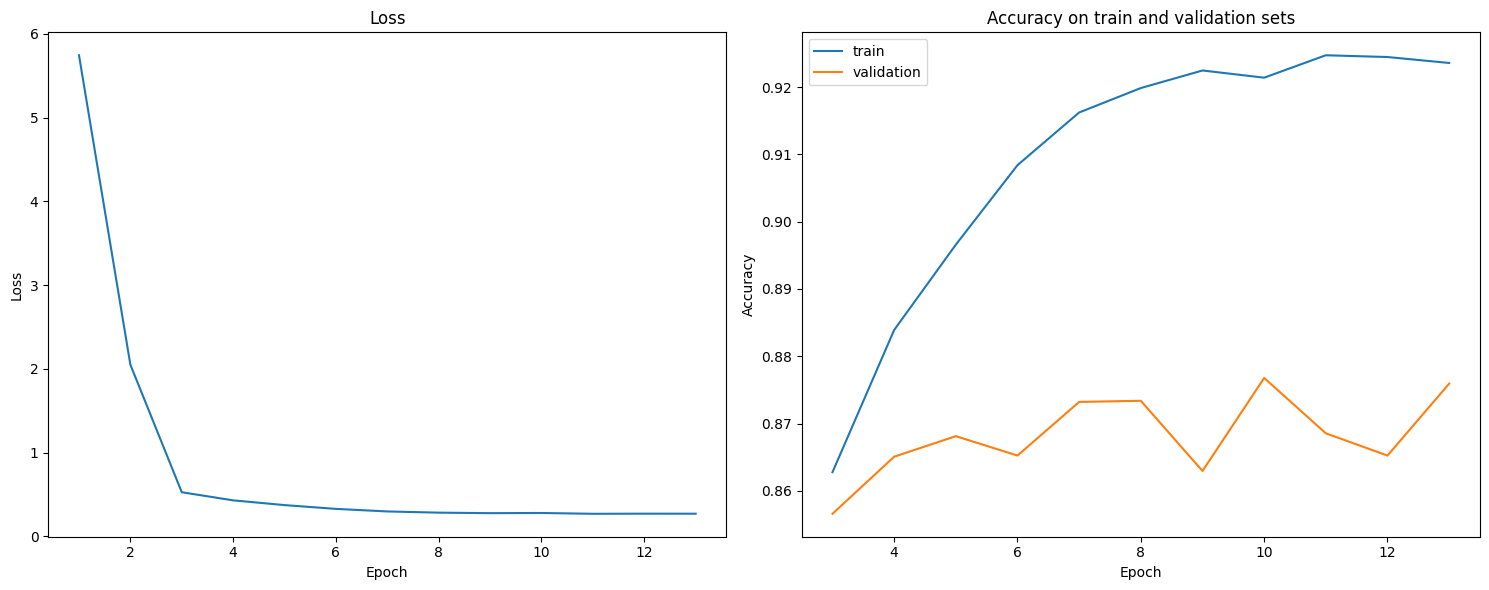

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(losses_df['epochs'], losses_df['losses'])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(metrics_df['epochs'], metrics_df['train_metrics'], label='train')
ax[1].plot(metrics_df['epochs'], metrics_df['val_metrics'], label='validation')
ax[1].set_title('Accuracy on train and validation sets')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
fig.tight_layout()
plt.show()

In [38]:
accuracy = calculate_accuracy(model, dataloaders['test'])
print(f'Accuracy on test set: {np.round(accuracy.item(), 2)}')

Accuracy on test set: 0.96


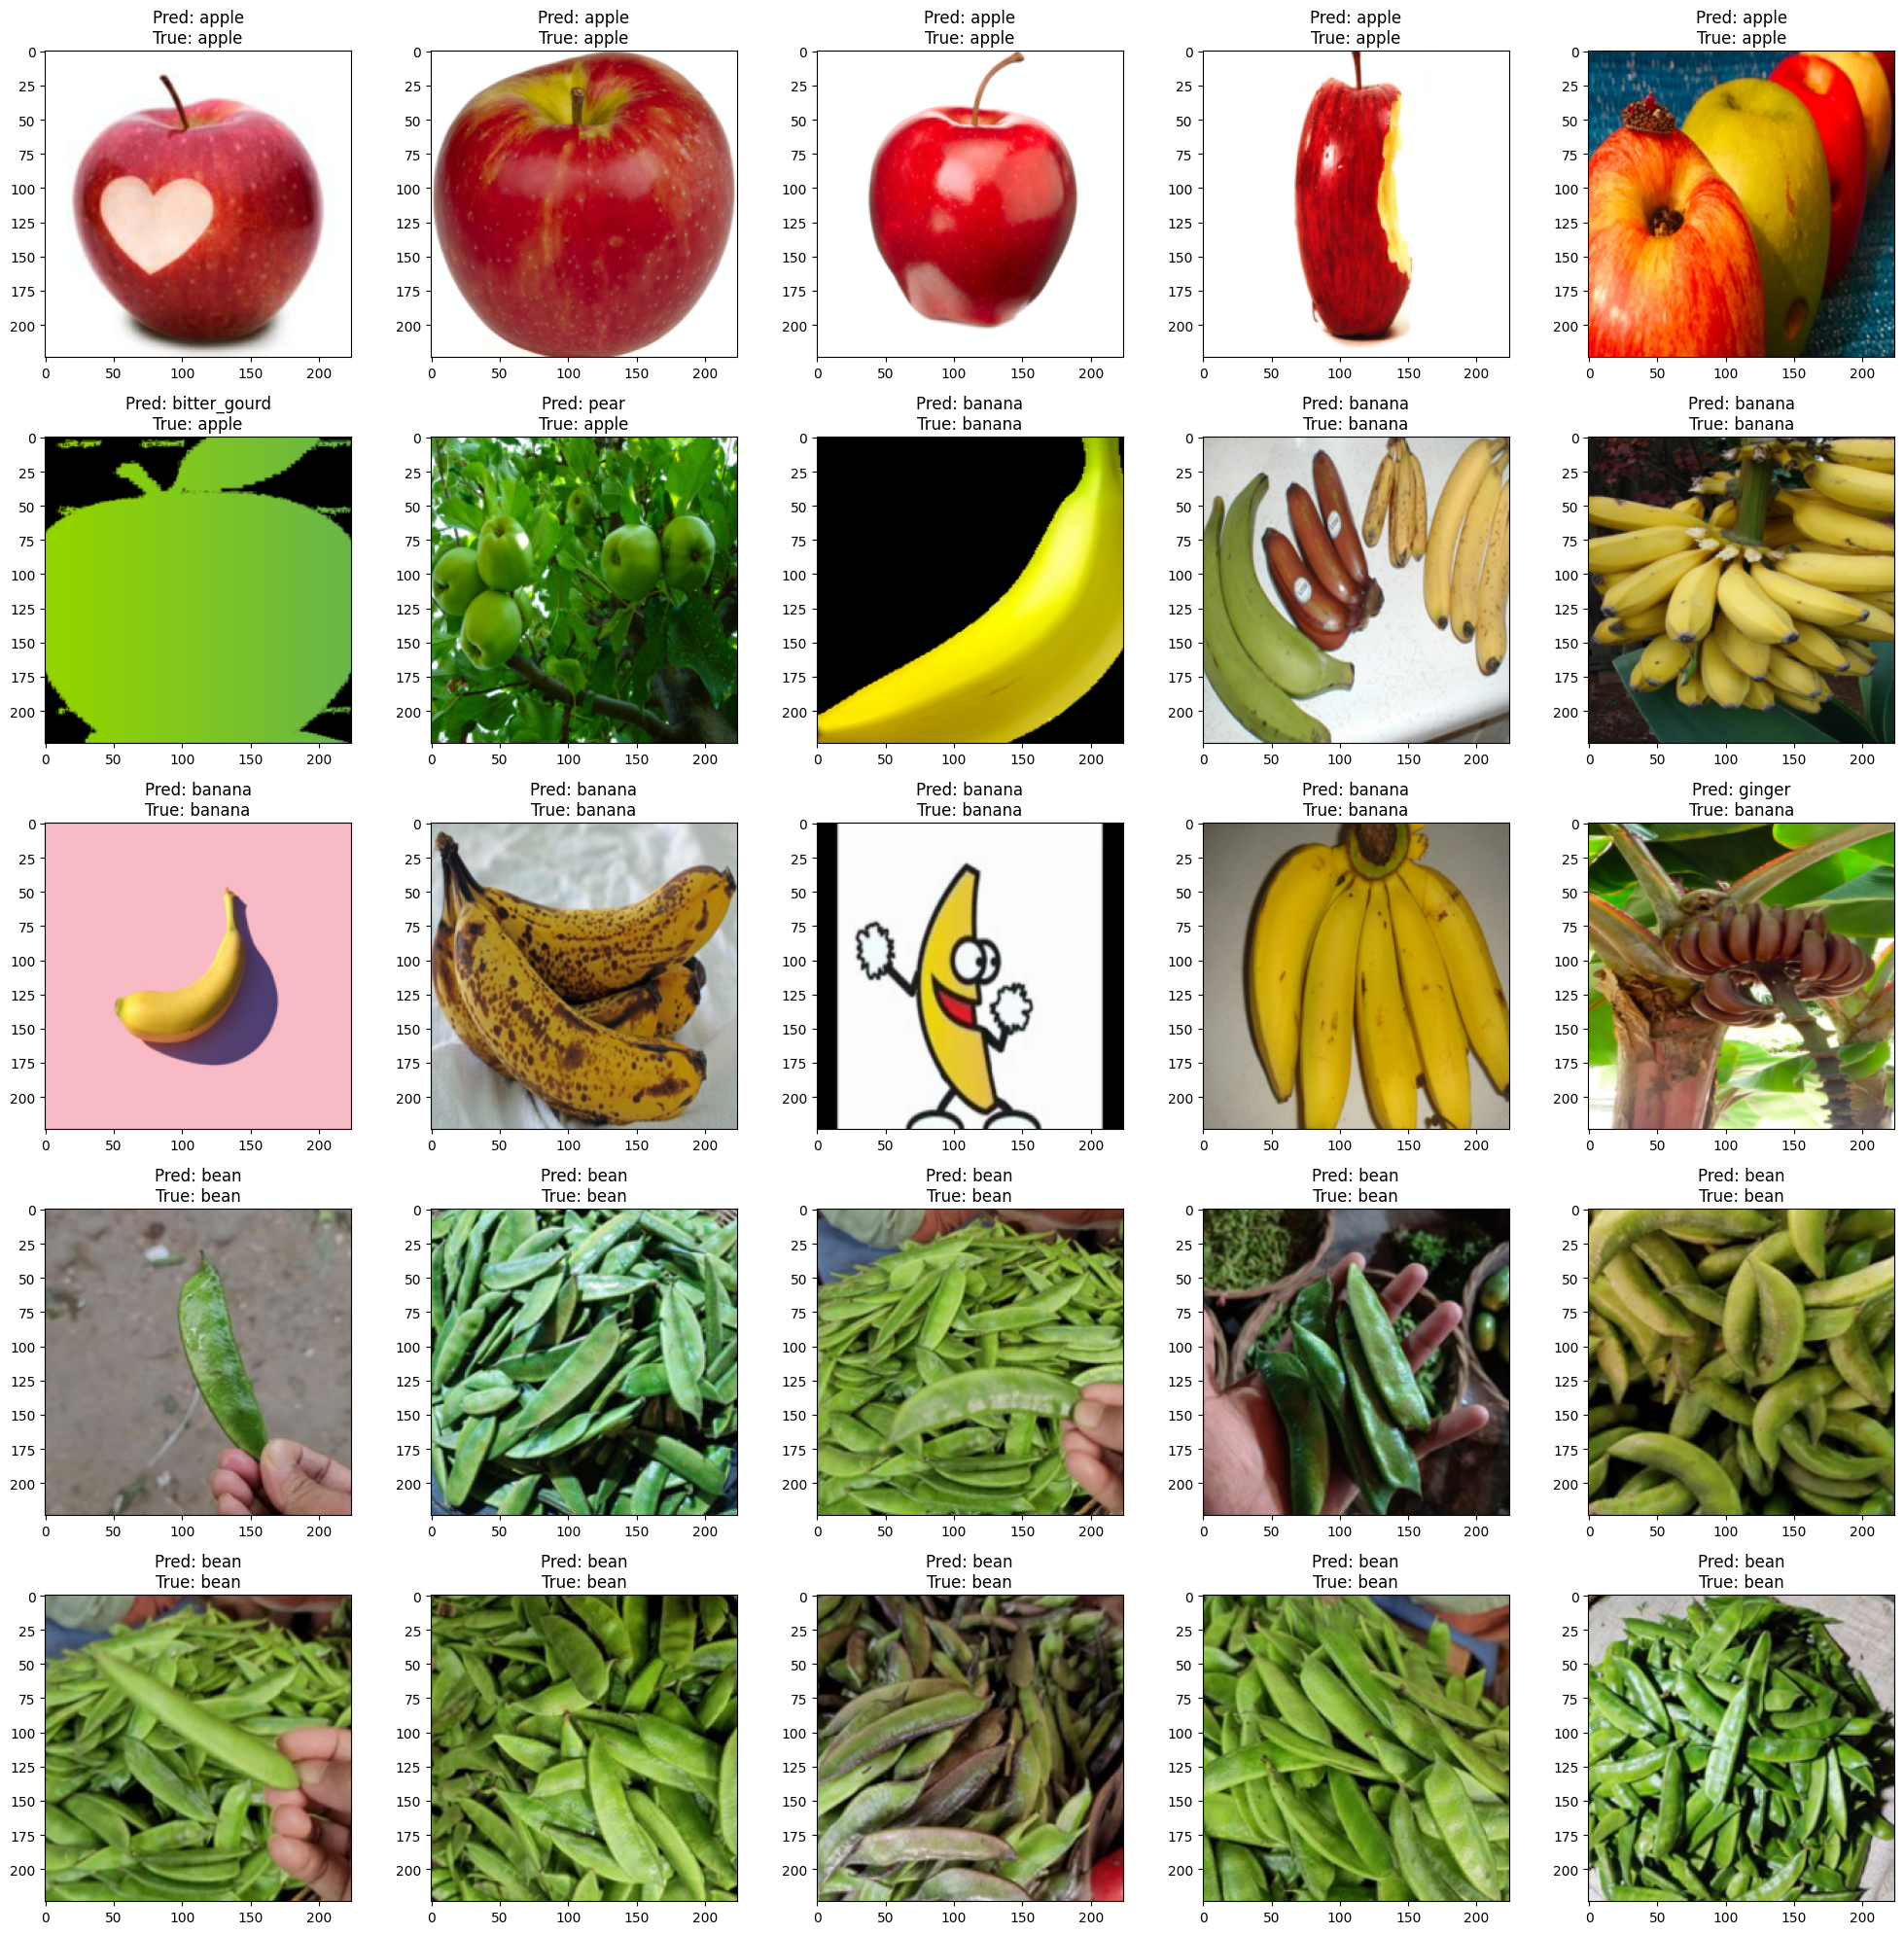

In [39]:
visualize_preds_on_test(model, grid_size=(5, 5))